In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import io
import seaborn as sns
import sklearn

# General Preprocessing of Data
1. filter for relevant subset: remove categorical features, only use data from 2017
2. removal of missing values

In [2]:
df = pd.read_csv('Data/air_quality_china1.csv', delimiter=',')

# preprocessing, remove categorical features
df.pop("station")
df.pop("wd")

# filter for data from 2017
is_2017 = df['year']==2017
df_2017 = df[is_2017]
cols = ["No","year","month","day","hour","PM2.5","PM10","SO2","NO2","CO","O3","TEMP","PRES","DEWP","RAIN","WSPM"]


# check data
df_2017.head()


,No,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,WSPM
33648,33649,2017,1,1,0,485.0,496.0,8.0,121.0,6100.0,4.0,-4.7,1022.1,-6.1,0.0,1.0
33649,33650,2017,1,1,1,477.0,497.0,7.0,113.0,6300.0,4.0,-5.2,1022.3,-6.4,0.0,0.7
33650,33651,2017,1,1,2,454.0,469.0,7.0,111.0,6200.0,4.0,-5.4,1022.5,-6.5,0.0,1.1
33651,33652,2017,1,1,3,418.0,425.0,6.0,109.0,5900.0,3.0,-5.2,1022.5,-6.2,0.0,1.1
33652,33653,2017,1,1,4,438.0,468.0,10.0,123.0,7700.0,16.0,-5.0,1021.9,-5.8,0.0,1.0


### Plot all features

In [ ]:
%matplotlib inline
sns.set()
cols_sel = ["PM2.5","PM10","SO2","NO2","CO","O3","TEMP","PRES","DEWP","RAIN","WSPM"]

sns.pairplot(df_2017)
# plt.savefig("Plots\distributions.png")

### Remove Nan values

In [4]:
air_data = df_2017.dropna(axis=0)

# Preprocessing for PCA/SVD task
1. Normalize and standardize
2. Select 4 features for pca
3. Categorize data into 4 groups in terms of air quality
4. Export preprocessed data into files
5. Plot normalized and standardized data

### Before normalizing, remove irrelevant columns: No, year, month, day, hour

In [5]:
air_data_sel = air_data.copy()
air_data_sel.pop("year")
air_data_sel.pop("No")
air_data_sel.pop("month")
air_data_sel.pop("hour")
air_data_sel.pop("day")
air_data_sel.head()

,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,WSPM
33648,485.0,496.0,8.0,121.0,6100.0,4.0,-4.7,1022.1,-6.1,0.0,1.0
33649,477.0,497.0,7.0,113.0,6300.0,4.0,-5.2,1022.3,-6.4,0.0,0.7
33650,454.0,469.0,7.0,111.0,6200.0,4.0,-5.4,1022.5,-6.5,0.0,1.1
33651,418.0,425.0,6.0,109.0,5900.0,3.0,-5.2,1022.5,-6.2,0.0,1.1
33652,438.0,468.0,10.0,123.0,7700.0,16.0,-5.0,1021.9,-5.8,0.0,1.0


In [6]:
# calculate stats for data
train_stats = air_data_sel.describe()
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
PM2.5,1361.0,95.495959,115.289980,3.0,12.0,47.00,141.00,713.0
PM10,1361.0,108.159442,118.938604,3.0,24.0,66.00,151.00,858.0
SO2,1361.0,21.029390,21.172972,2.0,7.0,14.00,28.00,164.0
NO2,1361.0,66.572373,45.271559,2.0,26.0,62.00,98.00,217.0
CO,1361.0,1683.174137,1874.163478,100.0,400.0,800.00,2400.00,9900.0
O3,1361.0,47.546657,32.338368,2.0,17.0,49.00,74.00,133.0
TEMP,1361.0,0.687956,4.588397,-9.7,-2.4,0.05,3.20,15.9
PRES,1361.0,1023.506160,5.844552,1002.1,1019.8,1023.70,1027.75,1036.6
DEWP,1361.0,-13.153784,6.597315,-31.3,-18.7,-12.30,-7.80,0.9
RAIN,1361.0,0.002719,0.037573,0.0,0.0,0.00,0.00,0.8


## Normalize using 1) z-score and 2) range norm

In [7]:

# PART 1: Normalize the data using standard deviation --> z-score standartization: mean = 0, std = 1
def z_score(x):
    return (x - train_stats['mean'])/ train_stats['std']

# PART 2: Normalize using range --> all values in range [0,1]
def norm_range(x):
    return (x - train_stats['min'])/ (train_stats['max'] - train_stats['min'])


In [8]:
data_zscore = z_score(air_data_sel)
data_norm = norm_range(air_data_sel)

### select features for PCA: pm2.5, pm10, o3, no2 
referring to CAQI European air quality index https://en.wikipedia.org/wiki/Air_quality_index#CAQI

In [9]:
cols_pca = ["PM2.5","PM10","NO2","O3"]
pca_data_norm = data_norm[cols_pca]
pca_data_zscore = data_zscore[cols_pca]

In [10]:
# calculate stats for data
norm_stats = pca_data_zscore.describe()
norm_stats = norm_stats.transpose()
norm_stats


,count,mean,std,min,25%,50%,75%,max
PM2.5,1361.0,5.383888e-17,1.0,-0.802290,-0.724226,-0.420643,0.394692,5.356095
PM10,1361.0,1.314974e-16,1.0,-0.884149,-0.707587,-0.354464,0.360191,6.304434
NO2,1361.0,-2.928509e-17,1.0,-1.426334,-0.896200,-0.100999,0.694202,3.322784
O3,1361.0,7.581698e-16,1.0,-1.408440,-0.944595,0.044942,0.818017,2.642475


## Grouping of measurements
#### to group measurements into categories, calculate mean of all normed columns
**Explanation for grouping:**
1. very low air quality: $0 <= x_{mean} <= 0.25$ mean over normed columns 
2. low air quality $0.25 < x_{mean} <= 0.5$
3. medium air quality $0.5 < x_{mean} <= 0.75$
4. good air quality $0.75 < x_{mean} <= 1$

In [11]:
rated_data = pca_data_norm.copy()
rated_data['mean'] = rated_data.mean(numeric_only=True, axis=1)

labels = {1: "very low air quality", 2: "low air quality", 3: "medium air quality", 4 : "good air quality"}

In [12]:
df = rated_data.copy()
df.loc[df['mean'] <= 0.25, 'cat'] = 4
df.loc[df['mean'] >= 0.25, 'cat'] = 3
df.loc[df['mean'] >= 0.50, 'cat'] = 2
df.loc[df['mean'] >= 0.75, 'cat'] = 1

df.pop('mean') # don't need mean anymore
df

,PM2.5,PM10,NO2,O3,cat
33648,0.678873,0.576608,0.553488,0.015267,3.0
33649,0.667606,0.577778,0.516279,0.015267,3.0
33650,0.635211,0.545029,0.506977,0.015267,3.0
33651,0.584507,0.493567,0.497674,0.007634,3.0
33652,0.612676,0.543860,0.562791,0.106870,3.0
...,...,...,...,...,...
35059,0.012676,0.030409,0.153488,0.709924,4.0
35060,0.014085,0.039766,0.200000,0.603053,4.0
35061,0.018310,0.039766,0.297674,0.427481,4.0
35062,0.025352,0.047953,0.395349,0.251908,4.0


### Save the normalized and standardized data into files

In [13]:
# save the normalized data with the columns for pca and the labels
df.to_csv(r'Data\data_4comp_norm_labeled.csv', index=False)

In [14]:
# save the standardized data for pca with labels as well
result = pd.concat([pca_data_zscore, df['cat']], axis=1)
result.to_csv(r'Data\data_4comp_std_labeled.csv', index=False)

# Plotting
### plot z-score standardized

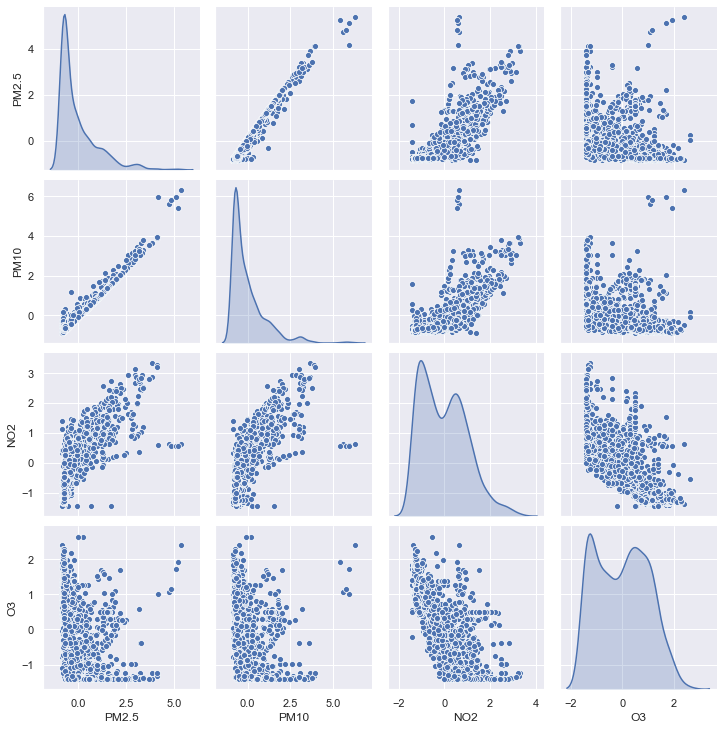

In [15]:
pca_data_zscore = result[cols_pca]
pca_data_norm = df[cols_pca]

sns.pairplot(pca_data_zscore, diag_kind="kde")

### plot range normalized


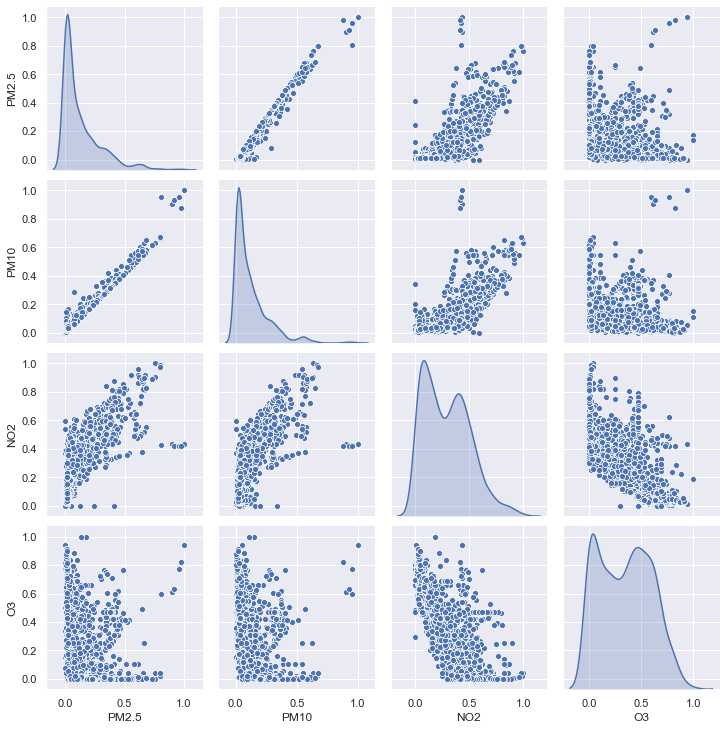

In [16]:
pca_data_norm = df[cols_pca]
sns.pairplot(pca_data_norm, diag_kind="kde")